In [12]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
import seaborn as sns

In [13]:
env = gym.make("Taxi-v3")
print("State Shape: ", env.observation_space.shape)
print("No of actions: ",env.action_space.n)
print("Action space sample: ", env.action_space.sample())
state, _ = env.reset()
print("Current state: ", state)
action = env.action_space.sample()
''' We take a random action now '''

print("Action", action)
print("----")

next_state, reward, done, _ , info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print("Next State: ", next_state)
print("Reward: ", reward)
print("Done: ", done)
print(info)
print("----")


State Shape:  ()
No of actions:  6
Action space sample:  3
Current state:  241
Action 4
----
Next State:  241
Reward:  -10
Done:  False
{'prob': 1.0, 'action_mask': array([1, 1, 1, 1, 0, 0], dtype=int8)}
----


In [14]:
def decompose_state(state):
    dest = int(state % 4)
    state = int(state/4)
    psg_loc = int(state%5)
    state = int(state/5)
    taxi_col = int(state%5)
    taxi_row = int(state/5)

    return taxi_row, taxi_col, psg_loc, dest

def compose_state(row, col, p_loc, dest):
    return ((row*5 + col)*5 + p_loc)*4 + dest

In [15]:
def choose_action(state_action_values, e, max = 6):
    if np.random.rand() < e or not np.any(state_action_values):
        return np.random.randint(0,max)
    else:
        return np.argmax(state_action_values)

In [16]:
gamma = 0.99
epsilon0 = 0.12
epsilon_decay = 0.99
alpha0 = 0.5
alpha_decay = 0.99983
alpha_min = 0.002

### Option MDPs:

In [17]:
gamma_o = 0.99
epsilon0_o = 0.12
epsilon_min_o = 0.002
epsilon_decay_o = 0.99965
alpha0_o = 0.5
alpha_min_o = 0.002
alpha_decay_o = 0.99983


In [19]:
class pick_option_MDP:
    def __init__(self, locations):
        self.Q = np.zeros((4,5,5,6)) # psg location (not in taxi), taxi_row, taxi_col, actions (navigation and interaction)
        # Target coordinate
        self.locations = locations
        self.epsilon = epsilon0_o
        self.alpha = alpha0_o
        
    
    def act(self, s0):
        '''
        Performs the sequence of actions according to the learned option policy
        No learning takes place
        '''

        r,c,p,_ = decompose_state(s0)
        if p == 4:
            return s0, 0, 0, 0, False, False, None
        
        option_reward = 0
        sum_reward = 0
        reward = 0
        step_count = 0
        g_i = 1
        terminated = truncated = False
        state_next = s0
        # print(f"start state: {decompose_state(s0)}")

        while(p<4):
            action = choose_action(self.Q[p,r,c], 0)
            state_next, reward, terminated, truncated, info = env.step(action)
            # print(f"action {action}, reward: {reward}, next state: {decompose_state(state_next)}")
            r2,c2,p2,_ = decompose_state(state_next)
            sum_reward += reward
            step_count += 1
            option_reward += reward * g_i
            g_i *= gamma
            # option_reward = option_reward * gamma + reward
            if terminated or truncated:
                return state_next, sum_reward, option_reward, step_count, terminated, truncated, None
            
            r,c,p = r2, c2, p2
       
        return state_next, sum_reward, option_reward, step_count, terminated, truncated, None

    def learn(self, episodes=1000):
        episode_rewards = np.empty(episodes)
        avg_rewards = np.empty(episodes)
        scores_window = deque(maxlen=100)

        for ep in tqdm(range(episodes)):
            s0, _ = env.reset()
            r,c,p,_ = decompose_state(s0)
            total_reward = 0

            while(p < 4):
                action = choose_action(self.Q[p,r,c],self.epsilon)
                state_next, reward, terminated, truncated, info = env.step(action)
                r2,c2,p2,_ = decompose_state(state_next)
                # print(f"Row: {r}, Col: {c} action:{action} r:{reward} trc:{truncated}")
                total_reward += reward

                if p2 == 4 or terminated or truncated:
                    break
                self.Q[p,r,c,action] = (1-self.alpha) * self.Q[p,r,c,action] + self.alpha * (reward + gamma_o * np.max(self.Q[p2, r2,c2]))
                p,r,c = p2, r2, c2

            
            episode_rewards[ep] = total_reward
            scores_window.append(total_reward)
            avg_rewards[ep] = np.mean(scores_window)

            if self.epsilon > epsilon_min_o:
                self.epsilon *= epsilon_decay_o
            if self.alpha > alpha_min_o:
                self.alpha *= alpha_decay_o


        plt.plot(range(episodes), episode_rewards)
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Pick Up Option Learning")
        # plt.legend(l)
        plt.show()

        


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4077.03it/s]


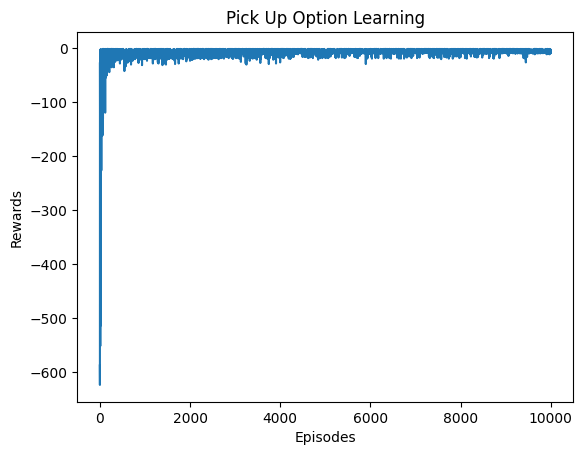

In [20]:
locations = [[0,0],[0,4],[4,0],[4,3]]
pick_option = pick_option_MDP(locations)

pick_option.learn(10000)

In [21]:
class drop_option_MDP:
    def __init__(self):
        self.Q = np.zeros((4,5,5,6)) # destination, taxi_row, taxi_col, actions (navigation and interaction)
        # Target coordinate
        self.epsilon = epsilon0_o
        self.alpha = alpha0_o
        
    
    def act(self, s0):
        '''
        Performs the sequence of actions according to the learned option policy
        No learning takes place
        '''

        r,c,p,d = decompose_state(s0)
        if p < 4:
            return s0, 0, 0, 0, False, False, None
        
        option_reward = 0
        sum_reward = 0
        reward = 0
        step_count = 0
        g_i = 1
        terminated = truncated = False
        state_next = s0
        # print(f"start state: {decompose_state(s0)}")

        while(p == 4):
            action = choose_action(self.Q[d,r,c], 0)
            state_next, reward, terminated, truncated, info = env.step(action)
            # print(f"action {action}, reward: {reward}, next state: {decompose_state(state_next)}")
            r2,c2,p2,d2 = decompose_state(state_next)
            sum_reward += reward
            step_count += 1
            option_reward += reward * g_i
            g_i *= gamma
            # option_reward = option_reward * gamma + reward
            if terminated or truncated:
                return state_next, sum_reward, option_reward,step_count, terminated, truncated, None
            
            r,c,p,d = r2, c2, p2, d2
       
        return state_next, sum_reward, option_reward, step_count, terminated, truncated, None

    def learn(self, episodes=1000):
        episode_rewards = []
        avg_rewards = []
        scores_window = deque(maxlen=100)

        for ep in tqdm(range(episodes)):
            s0, _ = env.reset()
            if episodes ==1:
                print(decompose_state(s0))
            s0, _,_,_,trm,trc,_ = pick_option.act(s0)
            if episodes ==1:
                print(decompose_state(s0))
            if trm or trc: 
                continue

            r,c,_,d = decompose_state(s0)
            total_reward = 0
            done = False
            steps = 0

            while not done:
                action = choose_action(self.Q[d,r,c],self.epsilon)
                state_next, reward, terminated, truncated, info = env.step(action)
                steps += 1
                done = terminated or truncated
                r2,c2,_,d2 = decompose_state(state_next)
                # print(f"Row: {r}, Col: {c} action:{action} r:{reward} trc:{truncated}")
                total_reward += reward

                self.Q[d,r,c,action] = (1-self.alpha) * self.Q[d,r,c,action] + self.alpha * (reward + gamma_o * np.max(self.Q[d2, r2,c2]))
                d,r,c = d2, r2, c2

                if episodes ==1:
                    print(decompose_state(state_next), reward)

                if steps>50:
                    # print( steps)
                    break
            if episodes ==1:
                print(total_reward)
            episode_rewards.append(total_reward)
            scores_window.append(total_reward)
            avg_rewards.append (np.mean(scores_window))

            if self.epsilon > epsilon_min_o:
                self.epsilon *= epsilon_decay_o
            if self.alpha > alpha_min_o:
                self.alpha *= alpha_decay_o


        plt.plot(range(len(avg_rewards)), avg_rewards)
        plt.xlabel("Episodes")
        plt.ylabel("Rewards")
        plt.title("Drop Option Learning")
        # plt.legend(l)
        plt.show()
        print(f"Average Reward: {avg_rewards[-1]}")
        


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2119.87it/s]


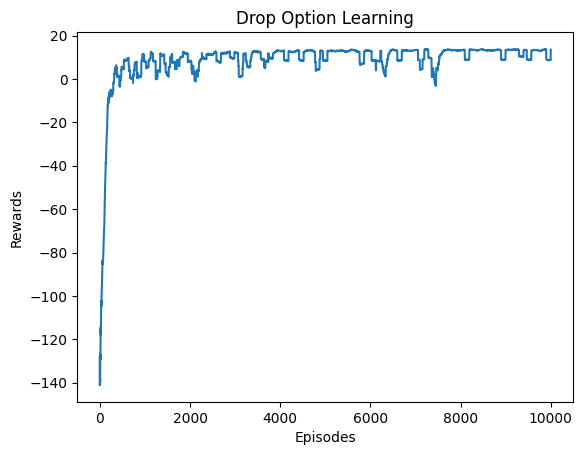

Average Reward: 13.49


In [22]:
drop_option = drop_option_MDP()
drop_option.learn(10000)

100%|██████████| 1/1 [00:00<00:00, 1095.12it/s]

(3, 1, 3, 0)
(4, 3, 4, 0)
(3, 3, 4, 0) -1
(2, 3, 4, 0) -1
(2, 2, 4, 0) -1
(2, 1, 4, 0) -1
(2, 0, 4, 0) -1
(1, 0, 4, 0) -1
(0, 0, 4, 0) -1
(0, 0, 0, 0) 20
13


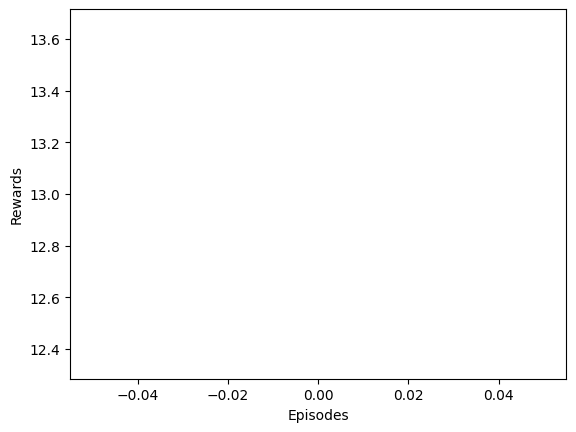

Average Reward: 13.0


In [11]:
drop_option.learn(1)

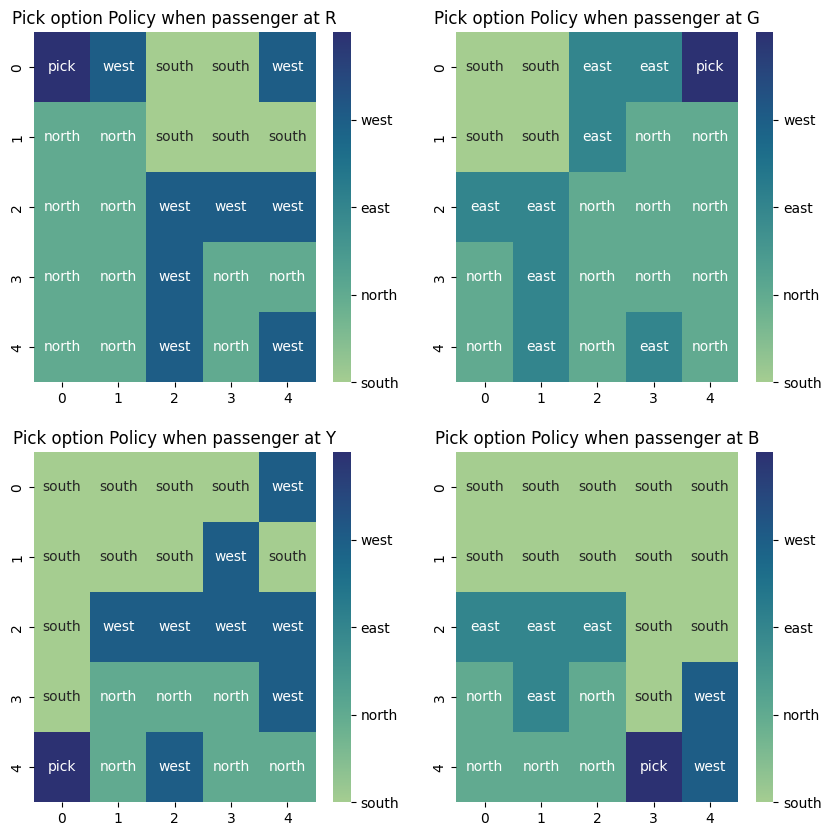

In [30]:
Labels = ['R', 'G', 'Y', 'B']
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pick', 5: 'drop'}
    annot_text = np.vectorize(labels.get)(np.argmax(pick_option.Q[2*i+j],axis=2).reshape(5,5))
    #ax = sns.heatmap(cmap"blues",np.argmax(options[2*i+j].Q, axis=2).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    ax = sns.heatmap(np.argmax(pick_option.Q[2*i+j], axis=2).reshape(5, 5), 
                         ax=axis[i, j], 
                         annot=annot_text, 
                         fmt='', 
                         cmap='crest',  # Fixed cmap syntax error
                         cbar_kws={"ticks": [0, 1, 2, 3]})  # Add colorbar ticks
        
    axis[i,j].set_title("Pick option Policy when passenger at {}".format(Labels[(i*2+j)]))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

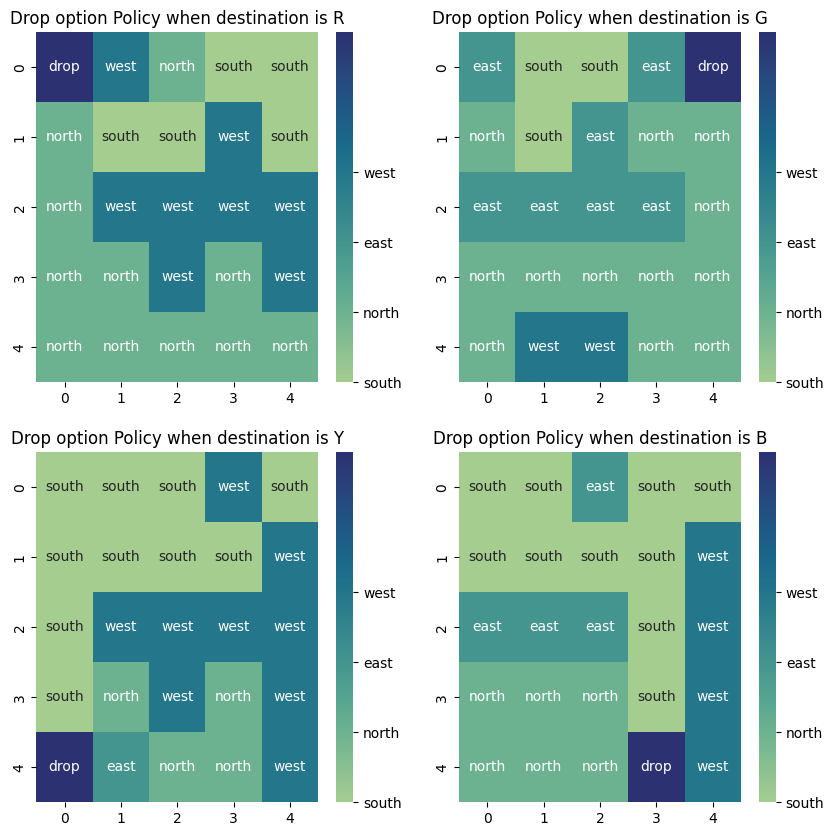

In [32]:
Labels = ['R', 'G', 'Y', 'B']
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pick', 5: 'drop'}
    annot_text = np.vectorize(labels.get)(np.argmax(drop_option.Q[2*i+j],axis=2).reshape(5,5))
    #ax = sns.heatmap(cmap"blues",np.argmax(options[2*i+j].Q, axis=2).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    ax = sns.heatmap(np.argmax(drop_option.Q[2*i+j], axis=2).reshape(5, 5), 
                         ax=axis[i, j], 
                         annot=annot_text, 
                         fmt='', 
                         cmap='crest',  # Fixed cmap syntax error
                         cbar_kws={"ticks": [0, 1, 2, 3]})  # Add colorbar ticks
        
    axis[i,j].set_title("Drop option Policy when destination is {}".format(Labels[(i*2+j)]))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])

In [13]:
def plot_all_Q(options, labels):
    UP, DOWN, LEFT, RIGHT = 0, 1, 2, 3
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    for i, option in enumerate(options):
        ax = axes[i]
        Q = option.Q
        policy = Q.argmax(-1)

        ax.set_title(f"Option Policy to Target {labels[i]}")
        c = ax.pcolor(Q.max(-1), edgecolors='k', linewidths=2, cmap='viridis')
        fig.colorbar(c, ax=ax)

        def x_direct(a):
            if a in [UP, DOWN]:
                return 0
            return 1 if a == RIGHT else -1

        def y_direct(a):
            if a in [RIGHT, LEFT]:
                return 0
            return 1 if a == UP else -1

        policyx = np.vectorize(x_direct)(policy)
        policyy = np.vectorize(y_direct)(policy)
        idx = np.indices(policy.shape)
        ax.quiver(idx[1].ravel() + 0.5, idx[0].ravel() + 0.5,
                  policyx.ravel(), policyy.ravel(), pivot="middle", color='red')

        ax.invert_yaxis()

    

    plt.tight_layout()
    plt.show()


In [14]:
labels = ['R', 'G', 'Y', 'B']
# plot_all_Q(options, labels)
"""
↑ corresponds to south
↓ corresponds to North
-> corresponds to West
<- corresponds to EAST
"""

'\n↑ corresponds to south\n↓ corresponds to North\n-> corresponds to West\n<- corresponds to EAST\n'

State: (1, 1, 1, 0)
state: (0, 4, 4, 0), reward: -7, d_ret: -6.793465209300999, False, False
state: (0, 0, 0, 0), reward: 12, d_ret: 10.72936333135041, True, False
State: (2, 1, 2, 0)
state: (4, 0, 4, 0), reward: -4, d_ret: -3.9403989999999998, False, False
state: (0, 0, 0, 0), reward: 16, d_ret: 15.271521199999999, True, False
State: (1, 3, 2, 3)
state: (4, 0, 4, 3), reward: -7, d_ret: -6.793465209300999, False, False
state: (4, 3, 3, 3), reward: 13, d_ret: 11.847841748838798, True, False
State: (1, 2, 1, 3)
state: (0, 4, 4, 3), reward: -4, d_ret: -3.9403989999999998, False, False
state: (4, 3, 3, 3), reward: 15, d_ret: 14.118805987999998, True, False
State: (1, 1, 2, 3)
state: (4, 0, 4, 3), reward: -5, d_ret: -4.90099501, False, False
state: (4, 3, 3, 3), reward: 13, d_ret: 11.847841748838798, True, False
State: (3, 2, 2, 0)
state: (4, 0, 4, 0), reward: -6, d_ret: -5.8519850599, False, False
state: (0, 0, 0, 0), reward: 16, d_ret: 15.271521199999999, True, False
State: (2, 2, 1, 0)
s

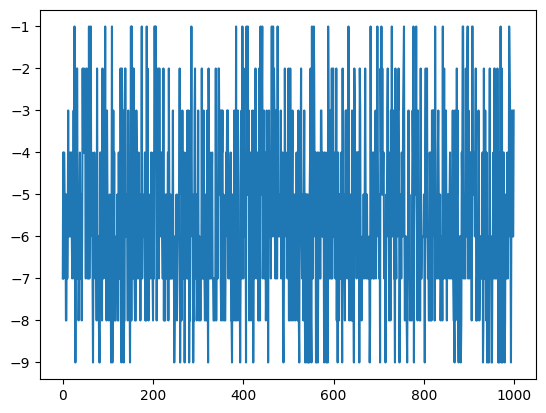

13.551


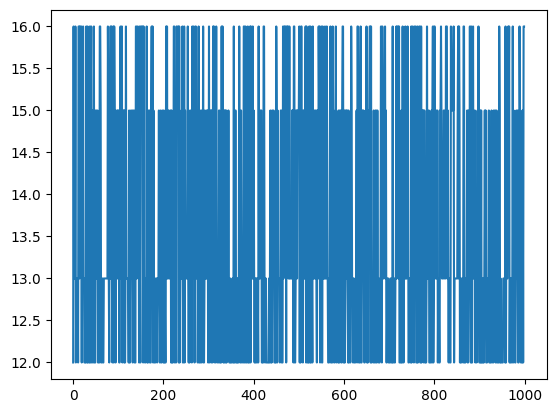

8.04


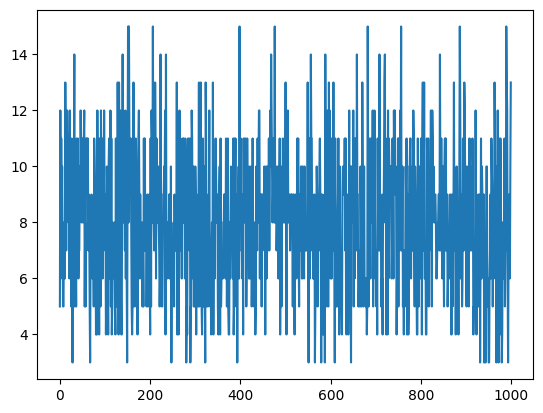

In [15]:
returns = []
r1 = []
r2 = []
for i in range(1000):
    total_reward = 0
    state, _ = env.reset()
    print("State:", decompose_state(state))
    state, sum_reward, dis_reward, step_count, terminated, truncated, info = pick_option.act(state)
    r1.append(sum_reward)
    print(f"state: {decompose_state(state)}, reward: {sum_reward}, d_ret: {dis_reward}, {terminated}, {truncated}")
    total_reward += sum_reward
    state, sum_reward, dis_reward, step_count, terminated, truncated, info = drop_option.act(state)
    print(f"state: {decompose_state(state)}, reward: {sum_reward}, d_ret: {dis_reward}, {terminated}, {truncated}")
    total_reward += sum_reward
    r2.append(sum_reward)
    returns.append(total_reward)

print(np.mean(r1))
plt.plot(range(len(r1)), r1)
plt.show()

print(np.mean(r2))
plt.plot(range(len(r2)), r2)
plt.show()

print(np.mean(returns))
plt.plot(range(len(returns)), returns)
plt.show()

In [16]:
options = [pick_option, drop_option]

In [25]:
class SMDP:
    def __init__(self):
        self.Q = np.zeros((5,4,2)) # passenger_location, destination, 2 options
        # Target coordinate
        self.epsilon = epsilon0
        self.alpha = alpha0
        
    
    # def act(self, s0):
    #     '''
    #     Return action according to learned option policy
    #     No learning takes place
    #     '''

    #     r,c,_,_ = decompose_state(s0)
    #     option_reward = 0
    #     terminated = truncated = False
    #     state_next = s0

    #     while(r != self.T_row or c!= self.T_col):
    #         action = choose_action(self.Q[r,c],self.epsilon)
    #         state_next, reward, terminated, truncated, info = env.step(action)
    #         r2,c2,_,_ = decompose_state(state_next)
    #         option_reward = option_reward * gamma + reward
    #         if terminated or truncated:
    #             return state_next, option_reward, terminated, truncated, None
            
    #         r,c = r2, c2

    #     _,_,p_loc,_ = decompose_state(state_next)
    #     if p_loc <4:
    #         state_next, reward, terminated, truncated, info = env.step(4)
    #     else:
    #         state_next, reward, terminated, truncated, info = env.step(5)
        
    #     option_reward = option_reward * gamma + reward
    #     return state_next, option_reward, terminated, truncated, None

    def learn(self, episodes=1000):
        episode_rewards = np.empty(episodes)
        avg_rewards = np.empty(episodes)
        scores_window = deque(maxlen=100)

        for ep in tqdm(range(episodes)):
            state, _ = env.reset()
            _,_,p,d = decompose_state(state)
            total_reward = 0
            done =0
            
            while not done:
                action = choose_action(self.Q[p,d],self.epsilon, max =2)
                state_next, sum_reward, disc_reward, step_count, terminated, truncated, info = options[action].act(state)
                done = terminated or truncated
                _,_,p2,d2= decompose_state(state_next)

                if episodes ==1:
                    print(f"state: {decompose_state(state)} action:{action} r:{sum_reward} trc:{truncated}, next state: {decompose_state(state_next)}")
                total_reward += sum_reward

                self.Q[p,d,action] = (1-self.alpha) * self.Q[p,d,action] + self.alpha * (disc_reward + (gamma**step_count) * np.max(self.Q[p2,d2]))
                
                p,d = p2,d2
                state = state_next
                
            if episodes ==1:
                print(f"total Reward: {total_reward}")
            episode_rewards[ep] = total_reward
            scores_window.append(total_reward)
            avg_rewards[ep] = np.mean(scores_window)

            # if self.epsilon > epsilon_min:
            self.epsilon *= epsilon_decay
            if self.alpha > alpha_min:
                self.alpha *= alpha_decay



        plt.plot(range(episodes), avg_rewards)
        plt.xlabel("Episodes")
        plt.ylabel("Avg_reward")


        


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:07<00:00, 140.05it/s]


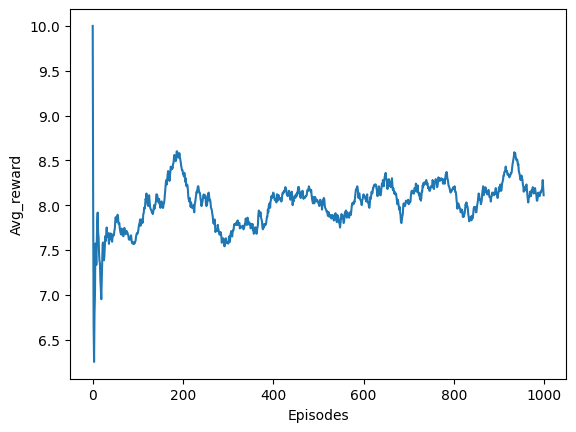

In [28]:
s = SMDP()
s.learn(1000)

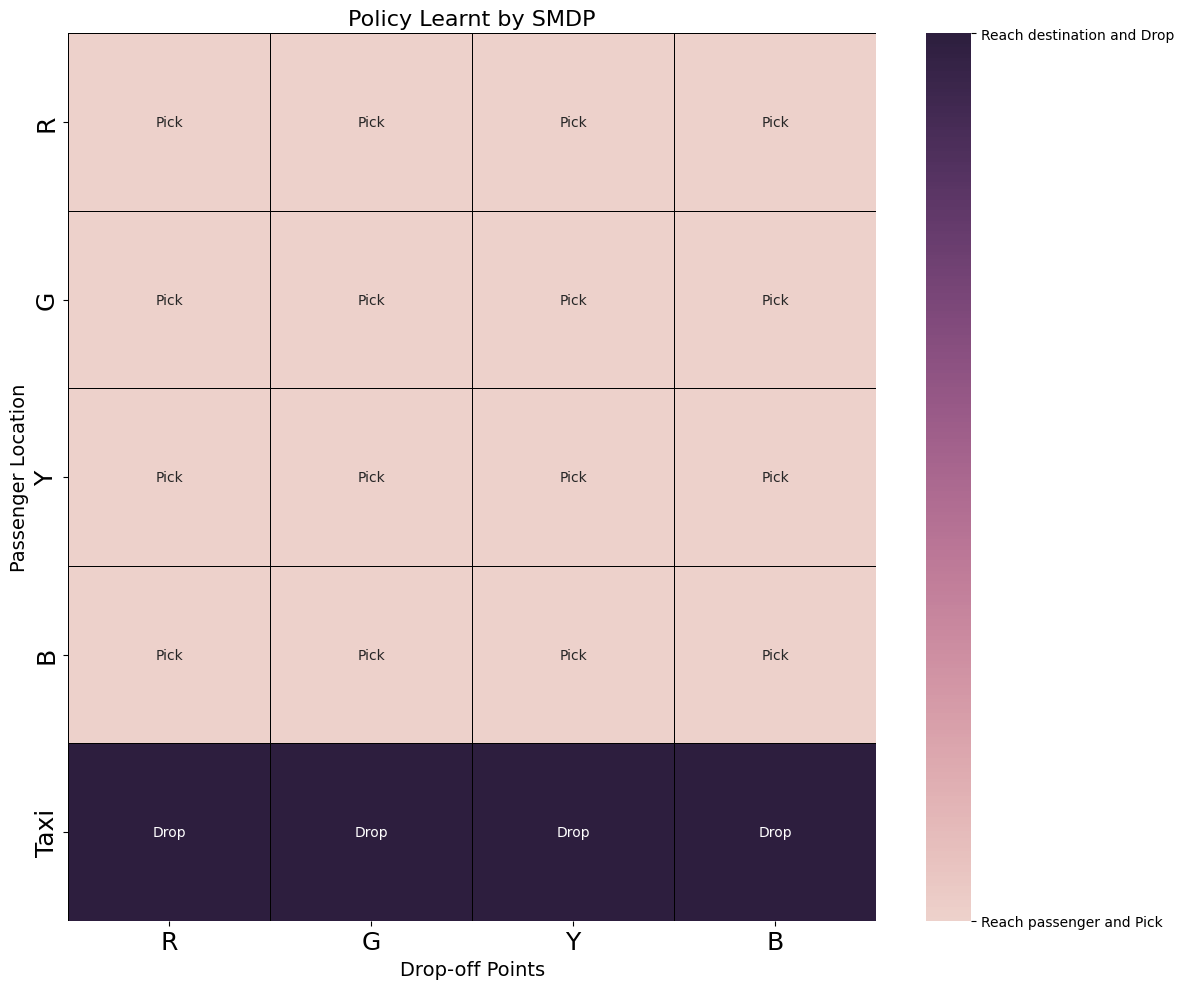

In [34]:
Qmax_SMDP = np.argmax(s.Q, axis=2).reshape(5, 4)
labels = {0: 'Pick', 1: 'Drop'}

# Apply labels to annotations
annot_text = np.vectorize(labels.get)(Qmax_SMDP)

# Create the plot
figure, axis = plt.subplots(1, 1, figsize=(12, 10))

# Plot the heatmap
sns.heatmap(Qmax_SMDP, 
            ax=axis,
            annot=annot_text, 
            fmt='',
            cmap=sns.cubehelix_palette(as_cmap=True),  # A more distinct color scheme
            xticklabels=["R", "G", "Y", "B"],
            yticklabels=['R', 'G', 'Y', 'B','Taxi'],
            cbar_kws={"ticks": [0, 1, 2, 3]},  # Fix color bar ticks to match actions
            linewidths=0.5,  # Thin grid lines
            linecolor='black')  # Color for grid lines

# Customize the colorbar
c_bar = axis.collections[0].colorbar
c_bar.set_ticks([0, 1])
c_bar.set_ticklabels(['Reach passenger and Pick', 'Reach destination and Drop'])

# Add labels and title
axis.set_xlabel('Drop-off Points', fontsize=14)
axis.set_ylabel('Passenger Location', fontsize=14)
axis.set_title('Policy Learnt by SMDP', fontsize=16)

# Enhance font size of the axis tick labels
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()